# Conventional classification

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [2]:
seed = 2020

df = pd.read_csv('../data/clean/10000_amazon_reviews_cleaned_stem.csv')
text_column = 'text'
label_column = 'label'

In [3]:
df.head(3)

,text,label
0,order short husband love fabric soft comfort c...,0
1,ninewest certainli know make great shoe high p...,0
2,look shaper great fit boot perfectli deliv wit...,0


 ### Class distribution

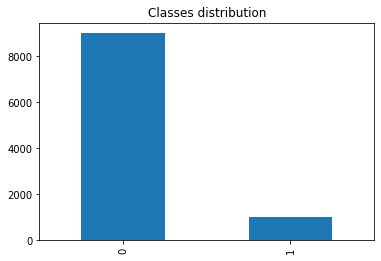

In [4]:
df[label_column].value_counts().plot.bar(title='Classes distribution')

# Classification with TF-IDF features

### Train-test split

In [5]:
X = df[text_column].values
y = df[label_column].values
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, 
                                                    test_size=test_size, shuffle=True)
print('Train size: {}'.format(X_train.shape))
print('Test size: {}'.format(X_test.shape))

Train size: (7001,)
Test size: (3001,)


## Grid search of hyperparameters for the models + TF-IDF features

In [20]:
# # To Use!
# hyperparams_grid = {
#     'LogisticRegression': {
#         'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'clf__penalty': ['l1', 'l2'],
#         'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 4}]
#     },
#     'MultinomialNB': {
#         'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
#     },
#     'LinearSVC': {
#         'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
#         'clf__penalty': ['l1', 'l2'],
#         'clf__loss': ['hinge', 'squared_hinge'],
#         'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 4}]
#     },
#     'RandomForestClassifier': {
#         'clf__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
#         'clf__bootstrap': [True, False],
#         'clf__max_depth': [10, 50, 100, None],
#         'clf__max_features': ['auto', 'sqrt'],
#         'clf__min_samples_leaf': [1, 2, 4],
#         'clf__min_samples_split': [2, 5, 10],
#         'clf__class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 4}]
#     }
# }

# To comment!
# hyperparams grid simplified
hyperparams_grid = {
 'LogisticRegression': {
        'clf__C': [1],
        'clf__penalty': ['l2'],
        'clf__class_weight': ['balanced']},
 'MultinomialNB': {
        'clf__alpha': [0.01, 0.1, 1]
    },
 'LinearSVC': {
        'clf__C': [0.1],
        'clf__penalty': ['l2'],
        'clf__loss': ['squared_hinge'],
        'clf__class_weight': ['balanced']
    },
 'RandomForestClassifier': {
    'clf__n_estimators': [600],
    'clf__bootstrap': [False],
    'clf__max_depth': [None],
    'clf__max_features': ['auto'],
    'clf__min_samples_leaf': [2],
    'clf__min_samples_split': [2],
    'clf__class_weight': ['balanced']
    }
}

In [22]:
models = [LogisticRegression(random_state=seed),
          MultinomialNB(),
          LinearSVC(random_state=seed),
          RandomForestClassifier(random_state=seed)]

k = 5  # number of splits in CV
cv_res = []

param_vectorizer = {
    'tfidf__max_features': [None],
    'tfidf__ngram_range': [(1, 3)]}

tfidf = TfidfVectorizer(min_df=3, max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words = None, lowercase=False)

for model in models: 
    pipeline  = Pipeline([
    ('tfidf', tfidf),
    ('clf', model)])
    
    model_name = model.__class__.__name__
    param_grid = {**param_vectorizer, **hyperparams_grid[model_name]}
    grid = GridSearchCV(pipeline, cv=k, param_grid=param_grid, scoring='f1', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)

    score_mean = grid.cv_results_['mean_test_score'][grid.best_index_]
    score_std = grid.cv_results_['std_test_score'][grid.best_index_]
    cv_res.append((model_name, score_mean, score_std, grid.best_params_))
    print('{} f1:{:1.3f} std: {:1.3f}, using {}'.format(model_name, score_mean, score_std, grid.best_params_))
    print('------------------------------------------------')

LogisticRegression f1:0.622 std: 0.049, using {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 3)}
------------------------------------------------
MultinomialNB f1:0.158 std: 0.045, using {'clf__alpha': 0.01, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 3)}
------------------------------------------------
LinearSVC f1:0.625 std: 0.043, using {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 3)}
------------------------------------------------
RandomForestClassifier f1:0.359 std: 0.031, using {'clf__bootstrap': False, 'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 600, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 3)}
------------------------------------------------


In [23]:
cv_df = pd.DataFrame(cv_res, columns=['model', 'f1_mean', 'f1_std', 'best_params']).set_index('model')
cv_df[['f1_mean', 'f1_std']]

,f1_mean,f1_std
model,,
LogisticRegression,0.622248,0.048793
MultinomialNB,0.158325,0.044668
LinearSVC,0.624514,0.042966
RandomForestClassifier,0.358649,0.030626


## Grid search of hyperparameters for the models + Counts features

In [ ]:
models = [LogisticRegression(random_state=seed),
          MultinomialNB(),
          LinearSVC(random_state=seed),
          RandomForestClassifier(random_state=seed)]

k = 5  # number of splits in CV
cv_res = []

count_vec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = None)

param_vectorizer = {
    'vect__ngram_range': [(1, 3)],
    'vect__max_features': [None]
}


for model in models:
    pipeline  = Pipeline([
    ('vect', count_vec),
    ('clf', model)])
    
    model_name = model.__class__.__name__
    param_grid = {**param_vectorizer, **hyperparams_grid[model_name]}
    print(param_grid)
    grid = GridSearchCV(pipeline, cv=k, param_grid=param_grid, scoring='f1', n_jobs=-1, verbose=-1)
    grid.fit(X_train, y_train)

    score_mean = grid.cv_results_['mean_test_score'][grid.best_index_]
    score_std = grid.cv_results_['std_test_score'][grid.best_index_]
    cv_res.append((model_name, score_mean, score_std, grid.best_params_))
    print('{} f1:{:1.3f} std: {:1.3f}, using {}'.format(model_name, score_mean, score_std, grid.best_params_))
    print('------------------------------------------------')

In [49]:
cv_df = pd.DataFrame(cv_res, columns=['model', 'f1_mean', 'f1_std', 'best_params']).set_index('model')
cv_df[['f1_mean', 'f1_std']]

,f1_mean,f1_std
model,,
LogisticRegression,0.503659,0.026129
MultinomialNB,0.231825,0.057562
LinearSVC,0.434033,0.026671
RandomForestClassifier,0.516495,0.039120


# Model Evaluation

### Compute TF-IDF features

In [50]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words = None, lowercase=False)

tfidf.fit(X_train)
# transform each document into a vectorv
X_train_tfidf = tfidf.transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print('Each of the %d documents is represented by %d features (TF-IDF score of unigrams and bigrams)' %(X_train_tfidf.shape))

Each of the 7001 documents is represented by 28963 features (TF-IDF score of unigrams and bigrams)


### Fit Model

In [72]:
# model = LogisticRegression(C=1, penalty='l2', class_weight='balanced', random_state=seed)
model = LinearSVC(C=1, penalty='l2', class_weight='balanced', loss='squared_hinge', random_state=seed)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

### Evaluate Model

In [73]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', beta=1)
print('*Evaluation on test data, {}*'.format(model.__class__.__name__))
print('f1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

*Evaluation on test data, LinearSVC*
f1:  0.6666666666666666
Precision:  0.7685589519650655
Recall:  0.5886287625418061


### Confusion Matrix

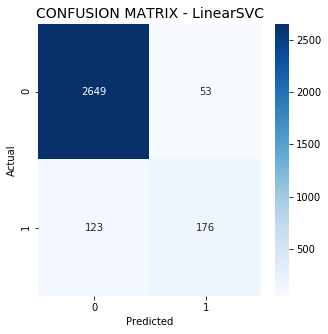

In [74]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
labels = df[label_column].unique()
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - {}".format(model.__class__.__name__), size=14);

### Misclassified test items

In [75]:
misclassified_idx = np.where(y_test != y_pred)
misclf_df = pd.DataFrame({'text_test':X_test[misclassified_idx], 'y_test': y_test[misclassified_idx]})
print('Misclassified test items:')
misclf_df

Misclassified test items:


,text_test,y_test
0,thank found wonder seri avail dvd enough said ...,0
1,realli surpris book publish deal ahp ahp ahp w...,1
2,thought book much humor adventer account remin...,0
3,'s call elect fraud media ever job hear lot nu...,1
4,go yet anoth attempt rip us fan offnumi care n...,1
...,...,...
171,book kill famili caus uncontrol fatal seizur w...,1
172,author build conceptu histori clearli explain ...,0
173,bought num fleec differ size size fleec proper...,1
174,profession librari would complet without book,0
